In [24]:
import numpy as np
import cv2
from PIL import Image,ImageEnhance
import copy
import matplotlib.pyplot as plt
from skimage import color
import random
import os

In [45]:
# Helper functions
# definition to readfile
def readfile(path):
    file = open(path, 'r')
    return file

# defintion to fetch bounding boxes
def fetch_bboxes(path):
    file = readfile(path)
    lines = file.readlines()
    # print(lines)
    bboxes = np.empty([len(lines),5], dtype=float)
    
    for i,line in enumerate(lines):
        # print(line)
        line = line.split()[0] + ' ' + ' '.join(line.split()[4:8])
        line = line.split()
        bboxes[i,:4] = line[1:]
    return bboxes

# defintion to fetch a random number
def gen_rand_num(begin,end):
    num = random.uniform(begin,end)
    return num

# definition to write augmented values to label file
def save_augbbox(auglabel_path,orig_path,bboxes):
    file_r = readfile(orig_path)
    lines = file_r.readlines()
    labels = []
    
    for i,line in enumerate(lines):
        #line[4:8] = '200 300 400 500'
        line = line.split()
        line[4:8] = [str(bbox) for bbox in bboxes[i,:4]]
        line = ' '.join(line)
        line = line + '\n'
        labels.append(line)
    file_w = open(auglabel_path + '.txt', 'w')
    file_w.writelines(labels)
    
# defintion to save augmented image    
def save_augimg(path, img_arr):    
    image = Image.fromarray(conv2uint8(img_arr))
    image.save(path + '.jpg')
    
# method to call save_augbbox and save_augimg
def save_augdata(image_info):
    save_augimg(image_info['augimg_path'] ,image_info['image_arr'])
    save_augbbox(image_info['auglabel_path'],image_info['origlabel_path'],
                 image_info['img_bboxes'])
    
def conv2uint8(image_arr):
    return (image_arr * 255).astype(np.uint8)

In [59]:
# For Spatial Augmentation
class Spatial_Aug:
    def __init__(self, image_path, label_path):
        self.image_arr = cv2.imread(image_path)/255
        # Convert to float32, as opencv only works with float32
        self.image_arr = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
        self.bboxes = fetch_bboxes(label_path)
        
    def hflip (self):
        # Fetching image width
        image_width = np.array(self.image_arr.shape[:2])[::-1][0]
        # Horizontally stacking image width for further perusal
        image_width = np.hstack((image_width, image_width))
        # Reversing the image co-ordinates in the 1st dimension
        # i.e Hz_flipping the image
        self.image_arr = self.image_arr[:,::-1,:]
        # Calculating the new distance from origin
        self.bboxes[:,[0,2]] = image_width - self.bboxes[:,[0,2]]
        # Interchanging  x1,x2 co-ordinates
        # Method 1: Calculating the bbox width
        box_width = abs(self.bboxes[:,0] - self.bboxes[:,2])
        self.bboxes[:,0] -= box_width
        self.bboxes[:,2] += box_width
        # Method 2: Swap co-ordinates
        #bbox_x1 = bboxes[:,0]
        #bboxes[:,0] = bboxes[:,2]
        #bboxes[:,1] = bbox_x1
        
        #return self.image_arr,self.bboxes
        return self
    
    def translate (self, TxTy = (8,8)):
        rows,cols = self.image_arr.shape[:2]
        # Making a transition matrix
        # Here the shift is Tx=Ty=8
        Tx,Ty = TxTy
        rand_x = gen_rand_num(0,Tx)
        rand_y = gen_rand_num(0,Ty)
        M = np.float32([[1,0,rand_x],[0,1,rand_y]])
        self.image_arr = cv2.warpAffine(self.image_arr,M,(cols,rows))
        self.bboxes[:,[0,2]] += rand_x
        self.bboxes[:,[1,3]] += rand_y
        return self

In [62]:
# For Color Augmentation
class Color_Aug:
    def __init__(self, image_path, label_path):
        self.image_arr = cv2.imread(image_path)/255
        self.image_arr = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2RGB)
        self.bboxes = fetch_bboxes(label_path)
    
    # definition to rotate hue of image
    def hue_rotate(self, hue_rot_max=0.5):    
        hsv = color.rgb2hsv(color.gray2rgb(self.image_arr))
        rand_hue_rot = gen_rand_num(0.1,hue_rot_max)
        #print("rand_hue_rot = ",rand_hue_rot)
        hsv[:, :, 0] = rand_hue_rot # adjust hue
        hsv[:, :, 1] = 1  # Turn up the saturation
        #return color.hsv2rgb(hsv)
        self.image_arr = color.hsv2rgb(hsv)
        return self
    
    """# defintion to adjust saturation
    def saturation(self, factor):
        rand_fact = gen_rand_num(0,factor)
        converter = ImageEnhance.Color(self.image)
        return converter.enhance(rand_fact)"""
    
    def saturation (self, factor=1.5):
        #imghsv = color.rgb2hsv(self.image_arr)
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        (h, s, v) = cv2.split(imghsv)
        factor = gen_rand_num(0.1,factor)
        # print("Random Factor = ",factor)
        s = s*factor
        s = np.clip(s,0,1)
        imghsv = cv2.merge([h,s,v])
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        self.image_arr = imgrgb
        return self
    
    """def contrast_scale(self, factor):
        factor = gen_rand_num(0.2,factor)
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        imghsv = cv2.convertScaleAbs(self.image_arr, alpha=factor, beta=0)
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        return imgrgb"""
    def brightness (self, factor=1.5):
        imghsv = cv2.cvtColor(self.image_arr.astype("float32"), cv2.COLOR_BGR2HSV)
        (h, s, v) = cv2.split(imghsv)
        factor = gen_rand_num(0.8,factor)
        # print("Random Factor = ",factor)
        v = v*factor
        v = np.clip(v,0,1)
        imghsv = cv2.merge([h,s,v])
        imgrgb = cv2.cvtColor(imghsv.astype("float32"), cv2.COLOR_HSV2BGR)
        self.image_arr = imgrgb
        return self       

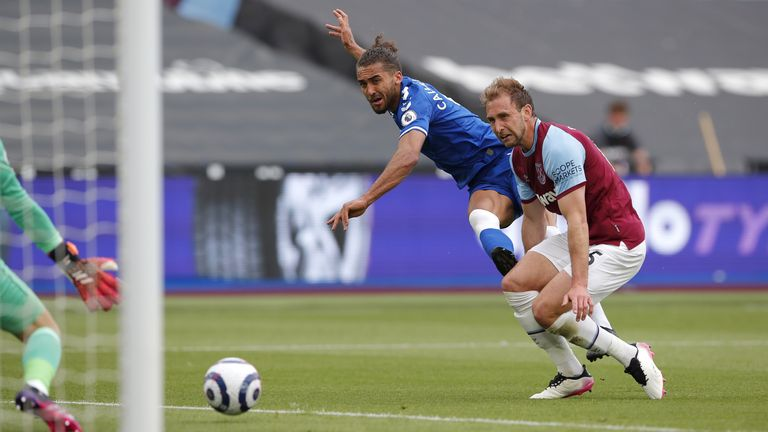

In [6]:
# Test code to fetch bounding boxes and image
from PIL import Image
image = Image.open('sports.jpg')
image

In [7]:
# Class mapping dictionary
test_class = {
    "Player" : 1.0,
    "Ball": 2.0
}

# Augmentation mapping
aug_dict = {
    "hflip":
    ""
}

In [8]:
# Draw bbox on image
# Ref from Paperspace blog
def draw_bbox(img, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    img : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """    
    img = img.copy()
    
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2])/200))
    return img

In [9]:
bboxes = fetch_bboxes('/workspace/experiment/' + 'sports.txt')
bboxes

array([[315.,   6., 514., 403.,   0.],
       [479.,  76., 667., 412.,   0.],
       [196., 348., 269., 423.,   0.]])

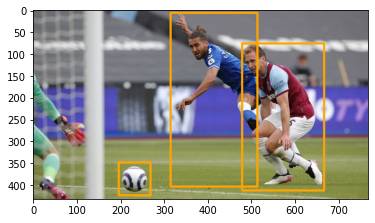

In [10]:
bbox_img = Image.fromarray(draw_bbox(np.asarray(image),
                                     bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_img)

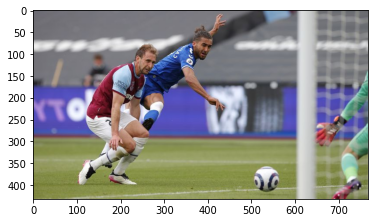

In [11]:
plt.imshow(Image.fromarray(np.asarray(image)[:,::-1,:]))

In [12]:
spat_aug = Spatial_Aug(image, label_path='/workspace/experiment/' + 'sports.txt')

In [13]:
spat_aug.image_arr.shape

(432, 768, 3)

In [14]:
spat_aug.bboxes

array([[315.,   6., 514., 403.,   0.],
       [479.,  76., 667., 412.,   0.],
       [196., 348., 269., 423.,   0.]])

In [15]:
aug_image_arr, aug_bboxes = spat_aug.hflip()

In [16]:
aug_image_arr.shape

(432, 768, 3)

In [17]:
aug_bboxes

array([[254.,   6., 453., 403.,   0.],
       [101.,  76., 289., 412.,   0.],
       [499., 348., 572., 423.,   0.]])

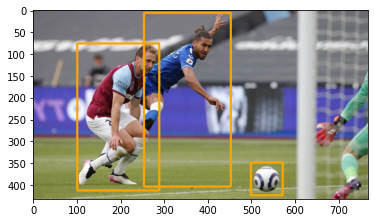

In [18]:
bbox_flipim = Image.fromarray(draw_bbox(conv2uint8(aug_image_arr),
                                     aug_bboxes[:,:4], color=[255,165,0]))
plt.imshow(bbox_flipim)

In [19]:
save_augdata('sports_hflip','sports.txt',aug_bboxes,aug_image_arr)

In [20]:
shift_img, shift_bboxes = spat_aug.translate((8,8))

In [21]:
shift_img[10]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.42573529, 0.42965686, 0.44926471],
       [0.42573529, 0.42965686, 0.44926471],
       [0.42242647, 0.42634804, 0.44595588]])

In [22]:
shift_bboxes

array([[261.24543387,   8.55827374, 460.24543387, 405.55827374,
          0.        ],
       [108.24543387,  78.55827374, 296.24543387, 414.55827374,
          0.        ],
       [506.24543387, 350.55827374, 579.24543387, 425.55827374,
          0.        ]])

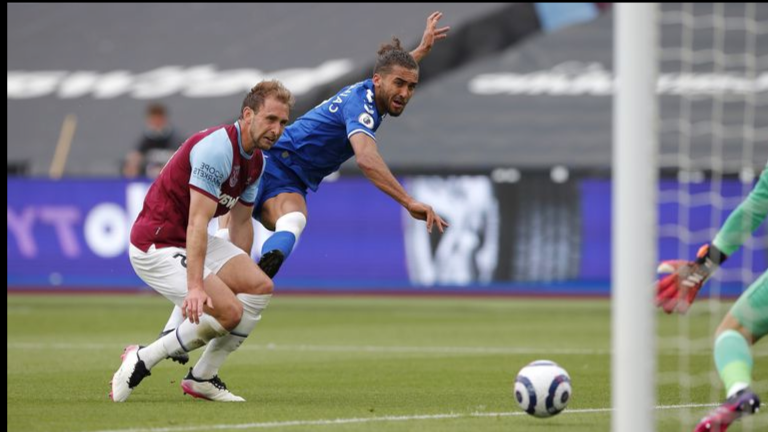

In [23]:
shift_img_view = Image.fromarray(conv2uint8(shift_img))
shift_img_view

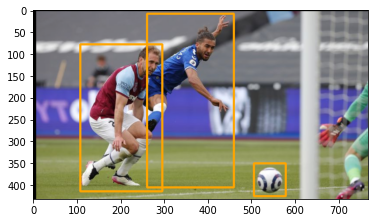

In [24]:
shfbbox_img = Image.fromarray(draw_bbox(conv2uint8(shift_img),
                                     shift_bboxes[:,:4], color=[255,165,0]))
plt.imshow(shfbbox_img)

In [837]:
col_aug = Color_Aug(image, label_path='/workspace/experiment/' + 'sports.txt')

In [648]:
col_aug.image_arr[0]

array([[0.39215686, 0.39607843, 0.41568627],
       [0.39607843, 0.4       , 0.41960784],
       [0.39607843, 0.4       , 0.41960784],
       ...,
       [0.45490196, 0.45098039, 0.48235294],
       [0.45490196, 0.45098039, 0.48235294],
       [0.45490196, 0.45098039, 0.48235294]])

In [27]:
col_aug.image_arr.shape

(432, 768, 3)

rand_hue_rot =  0.46192458062805075


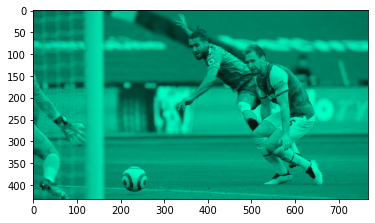

In [659]:
hue_img = col_aug.hue_rotate(0.5)
plt.imshow(hue_img)

In [650]:
np.array(hue_img)[0]

array([[0.        , 0.41568627, 0.23831088],
       [0.        , 0.41960784, 0.24055909],
       [0.        , 0.41960784, 0.24055909],
       ...,
       [0.        , 0.48235294, 0.27653054],
       [0.        , 0.48235294, 0.27653054],
       [0.        , 0.48235294, 0.27653054]])

Random Factor =  1.3651803960422977


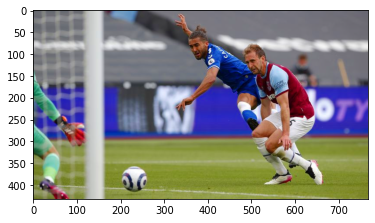

In [839]:
sat_img = col_aug.saturation(1.5)
plt.imshow(sat_img)

In [771]:
np.array(sat_img)[0]

array([[0.38341162, 0.3887907 , 0.41568628],
       [0.38733318, 0.39271227, 0.41960785],
       [0.38733318, 0.39271227, 0.41960785],
       ...,
       [0.44469914, 0.43932006, 0.48235294],
       [0.44469914, 0.43932006, 0.48235294],
       [0.44469914, 0.43932006, 0.48235294]], dtype=float32)

Random Factor =  1.3522262180669409


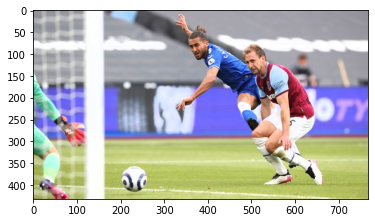

In [850]:
con_scale_img = col_aug.brightness(1.5)
plt.imshow(con_scale_img)

In [851]:
np.array(con_scale_img[0])

array([[0.5302848 , 0.5355876 , 0.5621019 ],
       [0.53558767, 0.54089046, 0.56740475],
       [0.53558767, 0.54089046, 0.56740475],
       ...,
       [0.6151303 , 0.6098275 , 0.6522503 ],
       [0.6151303 , 0.6098275 , 0.6522503 ],
       [0.6151303 , 0.6098275 , 0.6522503 ]], dtype=float32)

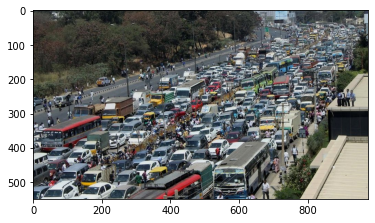

In [778]:
image_trf = Image.open('traffic.jpg')
plt.imshow(image_trf)

Random Factor =  1.0781902186127181


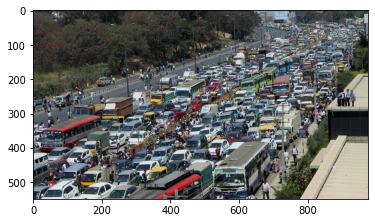

In [800]:
col_aug_trf = Color_Aug(image_trf, label_path='/workspace/experiment/' + 'sports.txt')
sat_img_trf = col_aug_trf.saturation(1.5)
plt.imshow(sat_img_trf)

In [6]:
impath = 'data/kitti/annotated_images/'
labels_path = 'data/kitti/labels/'
augtest_images = sorted(os.listdir(impath))
labels = sorted(os.listdir(labels_path))

In [7]:
imlabel_list = []
for entity in zip(augtest_images, labels):
    entity = list(entity)
    entity[0] = impath + entity[0]
    entity[1] = labels_path + entity[1]
    imlabel_list.append(tuple(entity))
print(imlabel_list)

[('data/kitti/annotated_images/2-wheeler-1.jpg', 'data/kitti/labels/2-wheeler-1.txt'), ('data/kitti/annotated_images/2-wheeler-10.jpg', 'data/kitti/labels/2-wheeler-10.txt'), ('data/kitti/annotated_images/2-wheeler-2.jpg', 'data/kitti/labels/2-wheeler-2.txt'), ('data/kitti/annotated_images/2-wheeler-3.jpg', 'data/kitti/labels/2-wheeler-3.txt'), ('data/kitti/annotated_images/2-wheeler-4.jpg', 'data/kitti/labels/2-wheeler-4.txt'), ('data/kitti/annotated_images/2-wheeler-5.jpg', 'data/kitti/labels/2-wheeler-5.txt'), ('data/kitti/annotated_images/2-wheeler-6.jpg', 'data/kitti/labels/2-wheeler-6.txt'), ('data/kitti/annotated_images/2-wheeler-7.jpg', 'data/kitti/labels/2-wheeler-7.txt'), ('data/kitti/annotated_images/2-wheeler-8.jpg', 'data/kitti/labels/2-wheeler-8.txt'), ('data/kitti/annotated_images/2-wheeler-9.jpg', 'data/kitti/labels/2-wheeler-9.txt'), ('data/kitti/annotated_images/2-wheeler.jpg', 'data/kitti/labels/2-wheeler.txt'), ('data/kitti/annotated_images/pedestrian_0.jpg', 'data/

In [63]:
# Randomizing augmentation class and type choice
spat_aug_dict = {
    'class' : Spatial_Aug,
    0 : 'hflip',
    1 : 'translate'
}

color_aug_dict = {
    'class' : Color_Aug,
    0 : 'hue_rotate',
    1 : 'saturation',
    2:  'brightness'
}

aug_classes = [spat_aug_dict, color_aug_dict]

In [64]:
image_info = {}
for i in range(0,2):
    for item in imlabel_list:
        print("Image File", item[0])
        # get the aug class
        aug_class = int(gen_rand_num(0,2))
        # get aug type
        num_types = len(aug_classes[aug_class]) - 1
        aug_type = int(gen_rand_num(0,num_types))
        # create aug class obj
        aug_class_obj = aug_classes[aug_class]['class'](item[0],item[1])
        # augment image_bbox object
        # aug_class_obj = aug_class_obj.aug_classes[aug_class][aug_type]
        # use get_attr to dynamically fetch the class method
        aug_class_method = getattr(aug_class_obj,aug_classes[aug_class][aug_type])
        # call the aug_type class method
        aug_class_obj = aug_class_method()
        # Fetching image, label names
        augimg_name = item[0][28:-4] + '_'  + aug_classes[aug_class][aug_type]
        auglabel_name = item[1][18:-4] + '_' + aug_classes[aug_class][aug_type]
        # Store image info in dictionary
        augimg_path = 'data/kitti/augmented_test/images/' + augimg_name
        auglabel_path = 'data/kitti/augmented_test/labels/' + auglabel_name
        origlabel_path = item[1]
        
        image_info['augimg_path'] = augimg_path
        image_info['auglabel_path'] = auglabel_path
        image_info['origlabel_path'] = origlabel_path
        image_info['img_bboxes'] = aug_class_obj.bboxes
        image_info['image_arr'] = aug_class_obj.image_arr
        
        save_augdata(image_info)

Image File data/kitti/annotated_images/2-wheeler-1.jpg
Image File data/kitti/annotated_images/2-wheeler-10.jpg
Image File data/kitti/annotated_images/2-wheeler-2.jpg
Image File data/kitti/annotated_images/2-wheeler-3.jpg
Image File data/kitti/annotated_images/2-wheeler-4.jpg
Image File data/kitti/annotated_images/2-wheeler-5.jpg
Image File data/kitti/annotated_images/2-wheeler-6.jpg
Image File data/kitti/annotated_images/2-wheeler-7.jpg
Image File data/kitti/annotated_images/2-wheeler-8.jpg
Image File data/kitti/annotated_images/2-wheeler-9.jpg
Image File data/kitti/annotated_images/2-wheeler.jpg
Image File data/kitti/annotated_images/pedestrian_0.jpg
Image File data/kitti/annotated_images/pedestrian_1.jpg
Image File data/kitti/annotated_images/pedestrian_2.jpg
Image File data/kitti/annotated_images/pedestrian_3.jpg
Image File data/kitti/annotated_images/pedestrian_4.jpg
Image File data/kitti/annotated_images/pedestrian_5.jpg
Image File data/kitti/annotated_images/2-wheeler-1.jpg
Image

In [17]:
""""test_obj = Spatial_Aug('data/kitti/annotated_images/2-wheeler-1.jpg', 'data/kitti/labels/2-wheeler-1.txt')
test_method = getattr(test_obj, spat_aug_dict[0])
test_method
myobj = test_method()"""

In [41]:
string = 'data/kitti/labels/2-wheeler-1.txt'
string[18:-4]

'2-wheeler-1'